# RapidWright Tutorial - SAT Router
In this Jupyter notebook tutorial, we: 
 1. Introduce a SAT-based solving engine for routing problems.
 2. Route an example that fails in Vivado but succeeds with the SAT Router.
 3. Show how to partially route a design with the SAT Router.
 
> **NOTE:** The SATRouter tools currently only operates in Linux environments, Windows support is not currently available.  

 
## Background
Routing congestion can be a difficult challenge in FPGA implementation.  Silicon is expensive and we want to use it as efficiently as possible---driving us to push the limits of FPGA fabric capabilities.  In doing so, often we experience challenges routing a design to completion. 

In this tutorial, we introduce a SAT engine (based on [MiniSAT](http://minisat.se/)) that has been instrumented for graph-type problem/solutions and a RapidWright interface leveraging its capabilities.  We have built a RapidWright interface to the SAT engine solver (based on work from [1]) such that routing problems can be described and routing solutions can be imported back into the RapidWright designs.   Note that the SAT solver is not a timing-driven router, but can solve exceptionally difficult congestion problems using an equal weight on routing wire lengths.  

[1] Fraisse, H., Gaitonde, D., *A SAT-based timing driven Place and Route flow for critical soft IP* (FPL 2018)


## Get Started!

### Difficult Congestion Example:
Start by running the code below (this code cell will take a 2-5 minutes to complete depending on the speed of your computer).  We begin with a design that has already been unsuccessfully routed by Vivado.  Our example design is a synthetic benchmark of a pipelined reduction OR circuit constrained to a small area.  Feel free to examine the design in Vivado (`reduce_or_routed_7overlaps.dcp`). Vivado's routing attempt failed with 7 overlaps in the routing that make it invalid. The code below unroutes the design (except for clock, GND and VCC) and provides the same PBlock to the SAT Router in order to route the design properly.  The SAT Router formulates the proper files to describe the problem and hands it off to the external tool `evRouter` (packaged with Vivado).  

In [ ]:
import os
from com.xilinx.rapidwright.router import SATRouter
from com.xilinx.rapidwright.design import Design
from com.xilinx.rapidwright.device import Device
from com.xilinx.rapidwright.design.blocks import PBlock

# Load our design that failed to route in Vivado
design = Design.readCheckpoint("reduce_or_routed_7overlaps.dcp")

# We will unroute all the nets (except clk, GND, VCC)
for net in design.getNets():
    if net.isClockNet() or net.isStaticNet():
        continue
    net.unroute()

# Load the same pblock used in the Vivado design for area constraint
# Note: the SAT Router will treat the pblock as if the CONTAIN_ROUTING
#       flag was set in Vivado
pblock = PBlock(design.getDevice(),"SLICE_X108Y660:SLICE_X111Y664")
satRouter = SATRouter(design,pblock)

# Here is where we actually invoke the external SAT router
# a few log files will be generated and this processs can take
# several minutes.  This command will also process the output
# result from the SAT router and import it back into the RapidWright
# design.
satRouter.route()

outputFileName = "reduce_or_sat_routed.dcp"
design.writeCheckpoint(outputFileName)
print "Wrote DCP '" + os.path.join(os.getcwd(), outputFileName) + "' successfully"

Once complete, we can open the resulting DCP ("reduce_or_sat_routed.dcp") in Vivado to examine the results.  Run the code cell below if your Jupyter Notebook server is local:

In [ ]:
# open up an instance of Vivado and load our freshly created DCP...
os.system("vivado "+outputFileName+" &")
print "If vivado fails to open or load, you could run the following command:"
print ""
print "    'vivado " + os.path.join(os.getcwd(), outputFileName) + "'"

To view the region of interest up close, you can select the pblock with the following Tcl command:

`select_objects [get_pblocks pblock_1]`

Then press `F9` to fit the selection to the window.

One key Tcl command to run when checking the validity of a route is `report_route_status` which can report on intimate details of the routing state.  Run the command in the Tcl prompt of your Vivado instance.  Here is an example of what the results might look like:

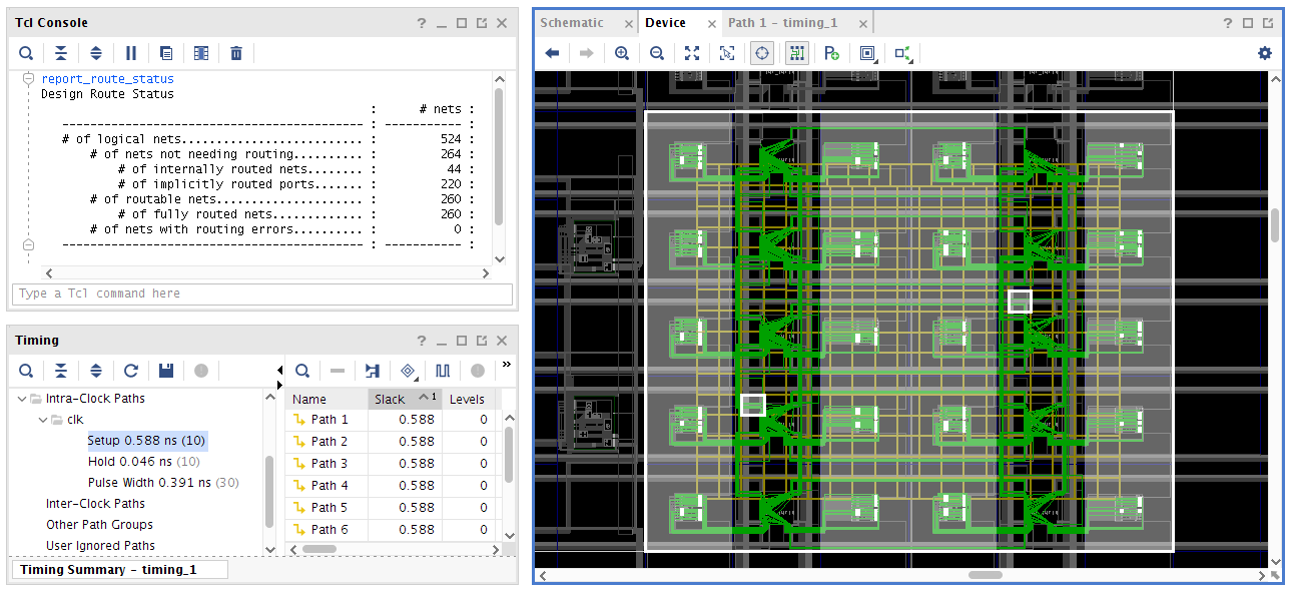

Once you are finished examining the design, **close** the file `reduce_or_sat_routed.dcp` to free up memory, but keep your Vivado instance open for the next example.

### Partial Routing Example:
Another use case for the SAT router is to partially route a portion of a design.  This can be useful if there is particularly difficult congestion in one part of the fabric.  To invoke the SAT Router, the same pattern is used by designating the area to be routed with a pblock, but this time we start with a fully placed design, run the SAT router to route our pblocked-area and then open it in Vivado for examination. (Again, the code cell below will take 2-5 minutes).

In [ ]:
import os
from com.xilinx.rapidwright.router import SATRouter
from com.xilinx.rapidwright.design import Design
from com.xilinx.rapidwright.device import Device
from com.xilinx.rapidwright.design.blocks import PBlock

# Load the same design used in the ILA Probe Re-router example
# we will unroute the design, so that we can route a portion 
# of it with the SAT router
design = Design.readCheckpoint("microblaze_with_ila_routed.dcp")
design.unrouteDesign()


# We will choose the area to be routed -- The SAT Router
# automatically determines which nets are physically within
# the pblock and will include them in the routing problem
# to the SAT Router
pblock = PBlock(design.getDevice(),"SLICE_X68Y134:SLICE_X72Y149")
satRouter = SATRouter(design,pblock)

# Here is where we actually invoke the external SAT router
# a few log files will be generated and this processs can take
# several minutes.  This command will also process the output
# result from the SAT router and import it back into the RapidWright
# design.
satRouter.route()

outputFileName = "microblaze_partially_sat_routed.dcp"
design.writeCheckpoint(outputFileName)
print "Wrote DCP '" + os.path.join(os.getcwd(), outputFileName) + "' successfully"

Opening the design in Vivado will show a rectangular block of routed signals in the design as shown below:

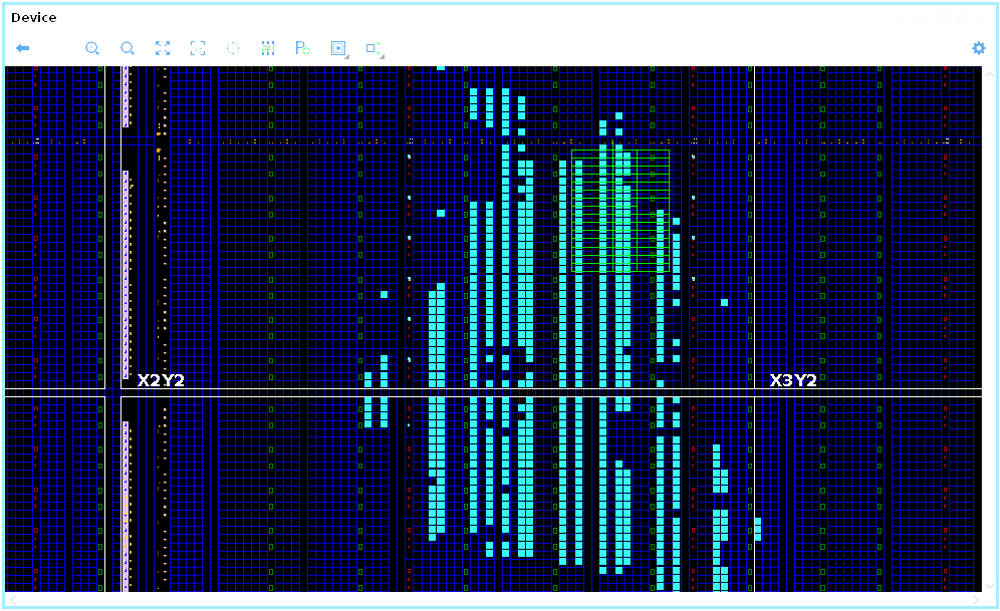

The SATRouter tool identified only the nets that exist inside the pblock'ed window and routed them, it did not attempt to route any outside the pblock.

As before, we can run `report_route_status` from the Tcl console in Vivado to check route status and see if there are any routing errors.  

Currently, the SAT Router is still under development and may not perform correctly for every design.  We welcome feed back to help improve its performance.